In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)
files = findFiles('data/*.txt')
print(files)
import re
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    lines = [s.lower() for s in lines]
    lines = [re.sub("[\t\s]", '', s) for s in lines]
    return lines

for filename in files:
    lines = readLines(filename)

['data/straattaal.txt']


In [3]:
import torch
torch.__version__

'1.8.0'

In [9]:
letters = set(" ".join(lines))
all_letters = ""
for s in letters:
    all_letters += all_letters.join(s)

n_letters = len(all_letters) + 1 # EOS
all_letters, len(all_letters), n_letters

('ntgarxubciyjleozwsfmp hvçkd', 27, 28)

In [11]:
modelpath = 'app/ml_models/rnn/'

In [9]:
with open(modelpath + '2019-11072021_all_letters.txt', 'r') as file:
    all_letters = file.read()
    file.close()
n_letters = len(all_letters) + 1 
all_letters

'moityuwnkçgzfvrxbasdehjlcp'

In [10]:
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [11]:
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [12]:
def randomChoice(l):
    return l[torch.randint(len(l), size=[1])]
def randomTrain():
    line = randomChoice(lines)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

In [13]:
inputs, target = randomTrain()
inputs.size(), target.size()

(torch.Size([4, 1, 27]), torch.Size([4]))

In [20]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, drop=0):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(drop)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.tanh(self.i2h(combined))
        output = self.i2o(hidden)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_letters)

In [15]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [16]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
rnn = RNN(n_letters, 128, n_letters)

In [17]:
def sample(model, start_letter='a', maxn=20, temp=1):
    with torch.no_grad():
        input = inputTensor(start_letter)
        hidden = model.initHidden()
        output_name = start_letter
        for i in range(maxn):
            output, hidden = model(input[0], hidden)
            if temp != 1:
                # print("use temp")
                probs = torch.softmax(output, 1) / temp
                # probs = output / temp
                dist = torch.distributions.Categorical(probs)
                pick = dist.sample()
            else:
                topv, topi = output.topk(1)
                pick = topi[0][0]
            if pick == n_letters - 1:
                break
            else:
                letter = all_letters[pick]
                output_name += letter
            input = inputTensor(letter)
        return output_name

In [22]:
from tqdm import tqdm

In [25]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in tqdm(range(1, n_iters + 1)):
    output, loss = train(*randomTrain())
    total_loss += loss

    if iter % print_every == 0:
        for i in range(3):
            word = sample(rnn, start_letter=randomChoice(all_letters), temp=1)
            if word not in lines:
                print(word, " X")
            else:
                print(word, " V")
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

  5%|██████▍                                                                                                                       | 5073/100000 [00:09<03:05, 512.00it/s]

haa  X
xaa  X
kaa  X
0m 8s (5000 5%) 2.1797


 10%|████████████▌                                                                                                                | 10090/100000 [00:18<02:24, 622.65it/s]

dana  X
wana  X
fana  X
0m 18s (10000 10%) 2.2779


 15%|██████████████████▊                                                                                                          | 15089/100000 [00:27<02:33, 552.13it/s]

eoen  X
jana  X
nana  X
0m 27s (15000 15%) 2.1736


 20%|█████████████████████████                                                                                                    | 20053/100000 [00:36<02:21, 564.14it/s]

bana  X
kanka  X
gana  X
0m 36s (20000 20%) 2.2237


 25%|███████████████████████████████▎                                                                                             | 25051/100000 [00:44<02:22, 525.98it/s]

xanga  X
janga  X
yanga  X
0m 44s (25000 25%) 1.5868


 30%|█████████████████████████████████████▌                                                                                       | 30092/100000 [00:52<01:54, 609.07it/s]

oenoe  X
langa  X
panga  X
0m 52s (30000 30%) 1.5092


 35%|███████████████████████████████████████████▉                                                                                 | 35107/100000 [01:02<01:50, 585.18it/s]

xang  X
oenoe  X
enie  X
1m 2s (35000 35%) 1.4831


 40%|██████████████████████████████████████████████████                                                                           | 40088/100000 [01:11<01:48, 554.34it/s]

lang  X
zang  X
vang  X
1m 11s (40000 40%) 1.8851


 45%|████████████████████████████████████████████████████████▎                                                                    | 45078/100000 [01:20<01:32, 596.46it/s]

sanga  X
lang  X
faka  V
1m 20s (45000 45%) 1.8814


 50%|██████████████████████████████████████████████████████████████▌                                                              | 50064/100000 [01:29<01:27, 569.06it/s]

faka  V
erie  X
taka  X
1m 29s (50000 50%) 1.9487


 55%|████████████████████████████████████████████████████████████████████▊                                                        | 55092/100000 [01:38<01:12, 620.03it/s]

lang  X
yang  X
dakken  X
1m 37s (55000 55%) 2.3818


 60%|███████████████████████████████████████████████████████████████████████████                                                  | 60096/100000 [01:46<01:05, 611.02it/s]

hoenoe  X
anga  X
roeka  X
1m 46s (60000 60%) 1.5345


 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 65088/100000 [01:54<01:06, 524.15it/s]

wakka  V
çaka  X
xroe  X
1m 54s (65000 65%) 1.7140


 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                     | 70106/100000 [02:03<00:51, 584.88it/s]

vaka  X
roeka  X
taka  X
2m 3s (70000 70%) 2.1367


 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 75053/100000 [02:13<00:45, 543.33it/s]

nassen  X
banga  X
daggie  X
2m 13s (75000 75%) 2.5192


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 80094/100000 [02:22<00:36, 552.08it/s]

gaa  X
sara  X
çaka  X
2m 22s (80000 80%) 1.2078


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 85096/100000 [02:31<00:25, 575.22it/s]

ula  X
yagg  X
yagg  X
2m 31s (85000 85%) 1.3608


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 90105/100000 [02:40<00:16, 602.23it/s]

zang  X
hoeroe  X
sara  X
2m 40s (90000 90%) 1.1203


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 95082/100000 [02:49<00:09, 523.75it/s]

angi  X
wagga  X
faka  V
2m 49s (95000 95%) 1.3721


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:57<00:00, 561.96it/s]

taka  X
taka  X
ula  X
2m 57s (100000 100%) 2.0358


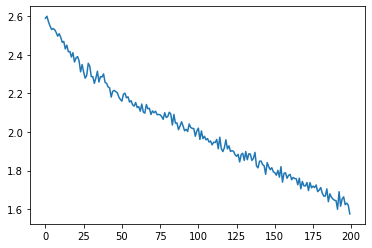

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()

In [27]:
for i in range(30):
    print(sample(rnn, start_letter=randomChoice(all_letters), temp=1))

# save model and letters

In [ ]:
from datetime import datetime
now = datetime.today().strftime("%H%M-%d%m%Y")
path = modelpath + now + "_straattaal.pth"
path

In [ ]:
torch.save(rnn.state_dict(), path)
print("Saved PyTorch Model State to {}".format(modelpath))

In [ ]:
with open(modelpath + now + "_all_letters.txt", "w") as text_file:
    text_file.write(all_letters)
    text_file.close()

# Load model and letters

In [1]:
modelpath = 'app/ml_models/rnn/'
with open(modelpath + '2019-11072021_all_letters.txt', 'r') as file:
    all_letters = file.read()
    file.close()
all_letters

'moityuwnkçgzfvrxbasdehjlcp'

In [21]:
modelname = modelpath + '2019-11072021_straattaal.pth'
model = RNN(n_letters, 128, n_letters, drop=0)
model.load_state_dict(torch.load(modelname))

<All keys matched successfully>

In [25]:
for i in range(30):
    print(sample(model, start_letter=randomChoice(all_letters), temp=1))

chilla
erie
pana
daggie
roeka
ingi
oeno
chilla
roeka
bakka
groeka
xroe
angi
angi
xroe
angi
joeka
sarama
angi
ula
oeno
zang
wagga
roeka
yaga
ingi
motta
motta
hoela
groeka
